# Feature Selection
----

<h4> Description </h4>
In this notebook I look for the best set of features. I also trying re-scaling the colors by subtraction the red-sequence mean color.

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Cosmos Sample

In [2]:
# path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
# fname = path+'desCosmosML_sample.fits'
# joined = Table(getdata(fname))

In [3]:
### get machine learning selection

In [4]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([x.T,y[:,1]]).T
    return xnew, ynew

In [21]:
path = '../data/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

# y_train_err = np.array(joined['smass_err'][joined['Train']])

In [22]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [23]:
x_train_small = x_train1d[:,4:]
x_test_small = x_test1d[:,4:]

x_test_small = x_test1d[:,4:]

## Cross Validation Sample

In [8]:
def convert_mag_to_fluxes(mag,f_o=10**12):
    return f_o*10.**(-mag/2.5)

def convert_mag_to_lupmag(mags, a=2.5*np.log10(np.exp(1)), f_o=10**12):
    # define quantities
    m_o = 2.5*np.log10(f_o)
    #mags = np.c_[g,r,i,z]
    fluxes = convert_mag_to_fluxes(mags)

    # sigma = 10**np.std(np.log10(fluxes),axis=0)
    sigma = np.array([28.79631884352346, 39.89162179800252, 67.37310780328083, 118.70759986796102]) # g,r,i,z
    b = np.sqrt(a)*sigma

    # define g,r,i,z fluxes as a numpy array
    # luptitudes and errors
    lups = (m_o - 2.5*np.log10(b)) - a*np.arcsinh(fluxes/(2*b))
    lup_errors = np.sqrt(((a**2) * (sigma**2)) / (4*(b**2) + (fluxes**2)))

    return lups, lup_errors
    
def get_input_galpro(mags, redshift, a=2.5*np.log10(np.exp(1)), f_o=10**12, normalize=False):
    # lupMags
    lups, lup_errors = convert_mag_to_lupmag(mags, a=a, f_o=f_o)
    g_r = lups[:, 0] - lups[:, 1]
    r_i = lups[:, 1] - lups[:, 2]
    i_z = lups[:, 2] - lups[:, 3]
    
    # red-sequence offset
    delta_gr = g_r #- np.interp(redshift,rsMean[0],rsMean[1])
    delta_ri = r_i #- np.interp(redshift,rsMean[0],rsMean[2])
    delta_iz = i_z #- np.interp(redshift,rsMean[0],rsMean[3])
    
    if normalize:
        delta_gr /= np.interp(redshift,rsMean[0],rsMean[4])
        delta_ri /= np.interp(redshift,rsMean[0],rsMean[5])
        delta_iz /= np.interp(redshift,rsMean[0],rsMean[6])
        
    # colour errors
    g_r_err = ((lup_errors[:, 0]**2) + (lup_errors[:, 1]**2))**0.5
    r_i_err = ((lup_errors[:, 1]**2) + (lup_errors[:, 2]**2))**0.5
    i_z_err = ((lup_errors[:, 2]**2) + (lup_errors[:, 3]**2))**0.5
    
    # abs mag
    distMod = cosmo.distmod(redshift).value
    absMags = lups-distMod[:,np.newaxis]

    # combining everything
    x_target = np.c_[lups, delta_gr, delta_ri, delta_iz, lup_errors, g_r_err, r_i_err, i_z_err, redshift]
    return x_target

In [9]:
from astropy.cosmology import WMAP9 as cosmo
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']

x_target = get_input_galpro(mags[mask],ztrue[mask])

distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]
x_target1d = np.c_[x_target,absMags[:,2]]

y_target = np.array(data['sdss_mass'][mask])
x_target_small = x_target1d[:,4:]

## Training with ML Architectures

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import time

# from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
n_cores = -1

ann_pipeline = make_pipeline(MLPRegressor(**ann_params))
rf_pipeline = make_pipeline(RandomForestRegressor(n_jobs=n_cores))
gradient_pipeline = make_pipeline(GradientBoostingRegressor())
svm_pipeline = make_pipeline(BaggingRegressor(SVR(), max_samples=1.0 / n_estimators,
                             n_estimators=n_estimators,n_jobs=n_cores))

estimators = [('ANN', ann_pipeline),
              ('Random Forest', rf_pipeline),
              ('Gradient Boosting', gradient_pipeline),
              ('SVM', svm_pipeline)]

In [41]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_small[idx,:]
y = y_train1d[idx]

In [43]:
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)/60.
    print('Elapsed time: %.2f min'%self.elapsed_time)
    
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 1.24 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 2.02 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 2.98 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 2.71 min



In [18]:
import pickle
# pickle.dump(estimators, open('fSelectionModel0.pkl', 'wb'))
estimators = pickle.load(open('fSelectionModel0.pkl', 'rb'))


# Optimization

In [19]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [31]:
def ann_objective(trial):
    params = {
        'alpha': trial.suggest_float("alpha", 0.0001, 1),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.1, step=0.005),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
    }
    model = MLPRegressor(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        alpha=params['alpha'],
        learning_rate_init=params['learning_rate_init'],
        activation='relu',
        random_state=1,
        max_iter=100
    )
    model.fit(x_train_small, y_train1d)
    
    return mean_squared_error(y_target, model.predict(x_target_small), squared=False)

In [32]:
import optuna
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

study = optuna.create_study(direction='minimize')
study.optimize(ann_objective, n_trials=3)

[I 2022-10-18 01:43:24,245] A new study created in memory with name: no-name-7a74bdc8-0aa9-47bb-bd81-3d77ef770461
[I 2022-10-18 01:44:03,763] Trial 0 finished with value: 1.2192970636867637 and parameters: {'alpha': 0.5590988313719549, 'learning_rate_init ': 0.0901, 'first_layer_neurons': 80, 'second_layer_neurons': 60}. Best is trial 0 with value: 1.2192970636867637.
[I 2022-10-18 01:45:32,892] Trial 1 finished with value: 0.2639616738865475 and parameters: {'alpha': 0.7207482891524928, 'learning_rate_init ': 0.0101, 'first_layer_neurons': 50, 'second_layer_neurons': 100}. Best is trial 1 with value: 0.2639616738865475.
[I 2022-10-18 01:46:23,570] Trial 2 finished with value: 0.47574330027816614 and parameters: {'alpha': 0.6761294499912128, 'learning_rate_init ': 0.07010000000000001, 'first_layer_neurons': 80, 'second_layer_neurons': 100}. Best is trial 1 with value: 0.2639616738865475.


In [39]:
ann_params = {'hidden_layer_sizes':(50,100),'alpha': 0.7207482891524928, 'learning_rate_init': 0.0101}


# Feature Selection

In [47]:
# from sklearn.feature_selection import SequentialFeatureSelector

# for (name, estimator) in [estimators[2]]:
#     print(name)
#     sfs_forward = SequentialFeatureSelector(
#         estimator, n_features_to_select=4, direction="forward"
#     ).fit(x_test_small, y_test1d)

In [ ]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(estimators[1][1].steps[0][1])
shap_values = explainer(x_target_small)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0])


In [ ]:
shap.plots.bar(shap_values)


In [44]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=3)
    ax.scatter(y_true, y_pred, alpha=0.9,s=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=16)
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
    
def median_abs_deviation(x,scale=1.0):
    return np.median(np.abs(x-np.median(x)))/scale

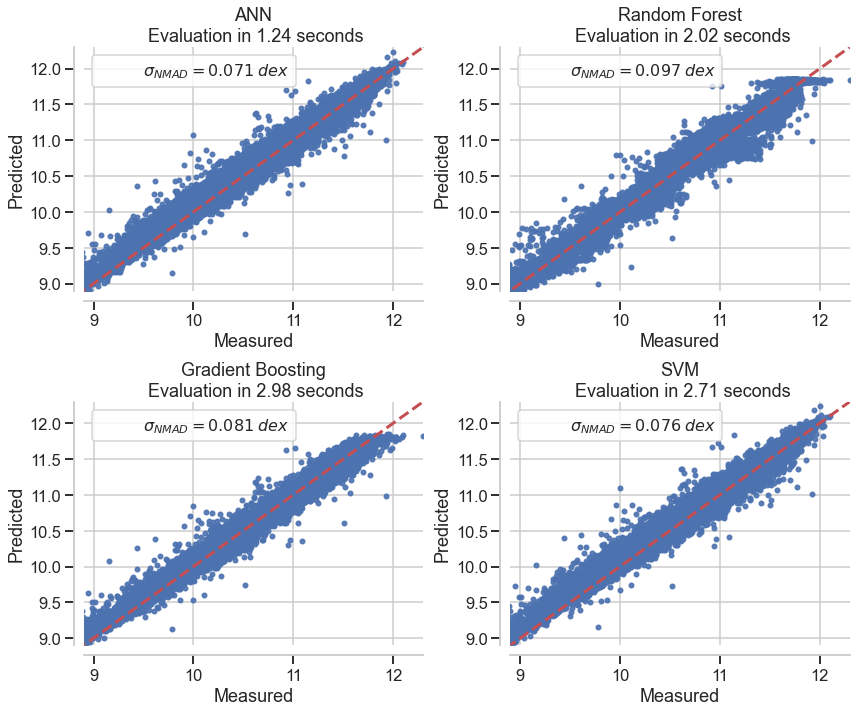

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_small)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,)
    ax.set_ylim(8.9,)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors.png',dpi=100,facecolor='w',transparent=False)

## Feature Importance

In [40]:
import time
import numpy as np

est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.152 seconds


In [41]:
feature_names = [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names+= [r'$M_i$']
feature_names

['$(g - r)$',
 '$(r - i)$',
 '$(i - z)$',
 'Mag_err_g',
 'Mag_err_r',
 'Mag_err_i',
 'Mag_err_z',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift',
 '$M_i$']

In [42]:
len(feature_names)

12

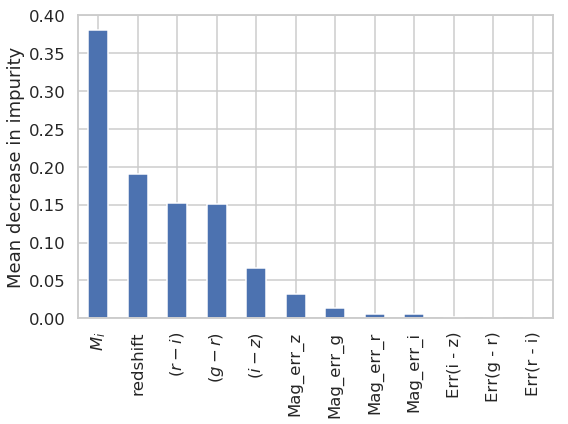

In [44]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

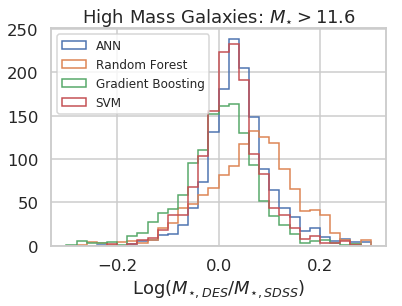

In [46]:
# xhigh = y_target>11.6
for name, est in estimators:
    ypred = est.predict(x_target_small)
    res = ypred-y_target
    yhigh = (ypred-np.median(res))>11.6
    plt.hist((res-np.median(res))[yhigh], bins=np.linspace(-0.3,0.3,31),histtype='step',label=name)
    plt.title('High Mass Galaxies: $M_{\star}>11.6$')
plt.xlabel('Log($M_{\star,DES}/M_{\star,SDSS}$)')
plt.legend(fontsize=12,loc=2)